# Initial Tests

In [1]:
import powerbox as pbox
import matplotlib.pyplot as plt
import numpy as np

/Users/sliemela/Environments/inverse_optim_env/lib/python3.7/site-packages/powerbox/dft.py:212: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")


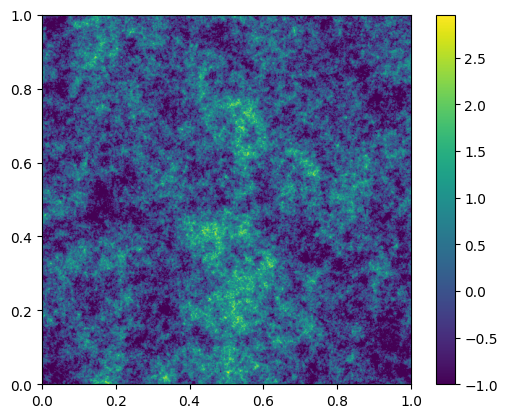

In [2]:
pb = pbox.PowerBox(
    N=512,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: 0.5*k**-2., # The power-spectrum
    boxlength = 1.0,           # Size of the box (sets the units of k in pk)
    seed = 1010,               # Set a seed to ensure the box looks the same every time (optional)
    ensure_physical=True       # ** Ensure the delta_x is a physically valid over-density **
)


plt.imshow(pb.delta_x(),extent=(0,1,0,1))
plt.colorbar()
plt.show()

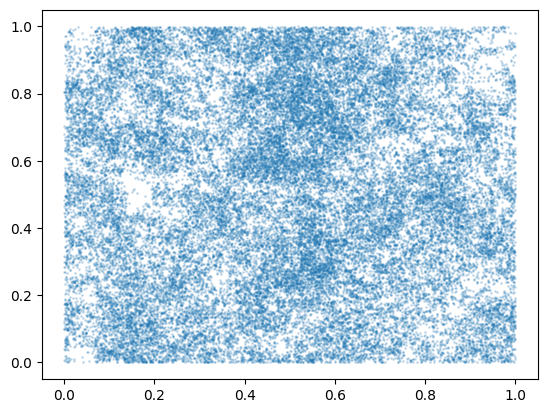

In [3]:
# Create a discrete sample using the PowerBox instance.
samples = pb.create_discrete_sample(nbar=50000,      # nbar specifies the number density
                                    min_at_zero=True  # by default the samples are centred at 0. This shifts them to be positive.
                                   )

# Plot the samples
plt.scatter(samples[:,0],samples[:,1], alpha=0.2,s=1)
plt.show()

In [4]:
# The number of grid points are also required when passing the samples
p_k_samples, bins_samples = pbox.get_power(samples, pb.boxlength,N=pb.N)

/Users/sliemela/Environments/inverse_optim_env/lib/python3.7/site-packages/powerbox/dft.py:121: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")


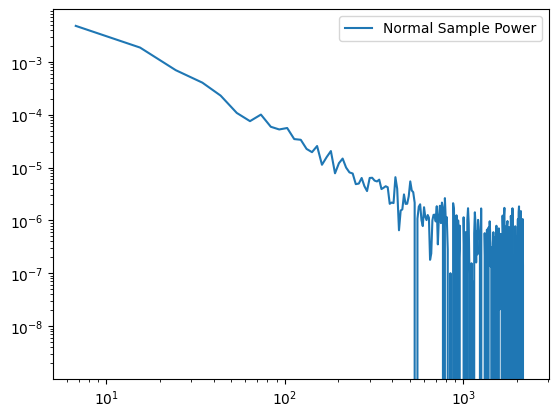

In [5]:
plt.plot(bins_samples, p_k_samples,label="Normal Sample Power")

plt.legend()
plt.xscale('log')
plt.yscale('log')

In [7]:
pb.boxlength

1.0

# Attempt to recreate GRF

In [2]:
%load_ext autoreload
%autoreload 2
%aimport

import matplotlib.pyplot as plt
import torch
import tensorflow as tf
import numpy as np
from inverse_optim import gen_data
from inverse_optim import research_plot
from inverse_optim import sancho
import tadasets
import tqdm

Modules to reload:
all-except-skipped

Modules to skip:



2023-03-15 14:11:01.408317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
pb = pbox.PowerBox(
    N=512,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: 0.5*k**-2., # The power-spectrum
    boxlength = 1.0,           # Size of the box (sets the units of k in pk)
    seed = 1410,               # Set a seed to ensure the box looks the same every time (optional)
    ensure_physical=True       # ** Ensure the delta_x is a physically valid over-density **
)


# Create a discrete sample using the PowerBox instance.
samples = pb.create_discrete_sample(nbar=1000,      # nbar specifies the number density
                                    min_at_zero=True  # by default the samples are centred at 0. This shifts them to be positive.
                                   )

pts = samples
samples = torch.tensor(samples)


In [7]:
# Creation of the PD that we want to get to
goal_pd = gen_data.create_hybrid_dtm_pd(samples)

100%|██████████| 300/300 [01:33<00:00,  3.21it/s]


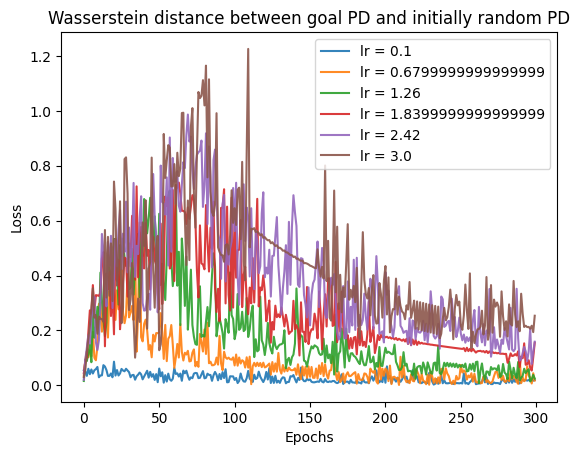

In [8]:
lr_list = np.linspace(0.1, 3, 6)
research_plot.research_lr(lr_list=lr_list, goal_pd=goal_pd, amount=samples.size(dim=0), dim=2, epochs=300, decay_speed=30, sliced=0.2, filtr="alpha_dtm")

100%|██████████| 300/300 [00:32<00:00,  9.19it/s]


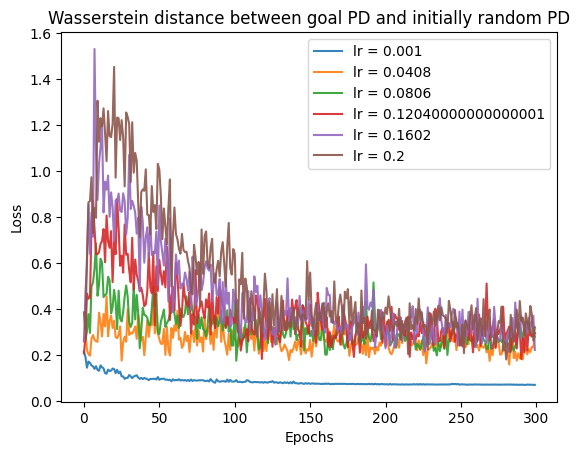

In [13]:
lr_list = np.linspace(0.001, 0.2, 6)
research_plot.research_lr(lr_list=lr_list, goal_pd=goal_pd, amount=samples.size(dim=0), dim=2, epochs=300, decay_speed=30, sliced=False, filtr="alpha_dtm")

In [96]:
final_pts = gen_data.generate_data(goal_pd=goal_pd, amount=samples.size(dim=0), lr=0.6, dim=2, epochs=300, decay_speed=30, sliced=0.2, filtr="alpha_dtm")

NameError: name 'samples' is not defined

In [10]:
# The number of grid points are also required when passing the samples
p_k_samples, bins_samples = pbox.get_power(pts, pb.boxlength, N=pb.N)
p_k_samples_new, bins_samples_new = pbox.get_power(final_pts.detach().numpy(), pb.boxlength, N=pb.N)

/Users/sliemela/Environments/inverse_optim_env/lib/python3.7/site-packages/powerbox/dft.py:121: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")


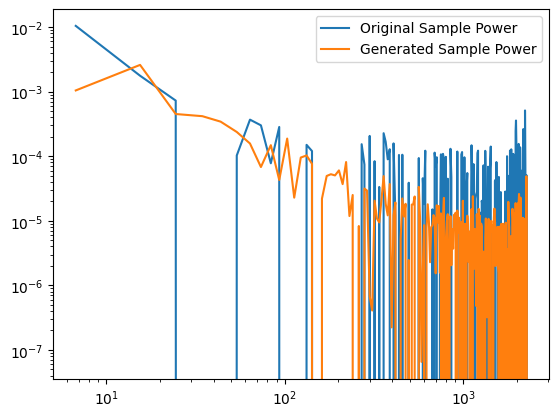

In [95]:
plt.plot(bins_samples, p_k_samples,label="Original Sample Power")
plt.plot(bins_samples_new, p_k_samples_new,label="Generated Sample Power")

plt.legend()
plt.xscale('log')
plt.yscale('log')

In [3]:
test_pts = np.random.random((samples.size(dim=0), 2))
p_k_samples_test, bins_samples_test = pbox.get_power(test_pts, 1.0, N=samples.size(dim=0))
plt.plot(bins_samples_test, p_k_samples_test,label="Random Sample Power", alpha=0.4)
plt.plot(bins_samples, p_k_samples,label="Original Sample Power")
plt.plot(bins_samples_new, p_k_samples_new,label="Generated Sample Power")

plt.legend()
plt.xscale('log')
# plt.yscale('log')

NameError: name 'samples' is not defined

# Perturbing GRF's with Inverse Optimization

/Users/sliemela/Environments/inverse_optim_env/lib/python3.7/site-packages/powerbox/dft.py:212: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")


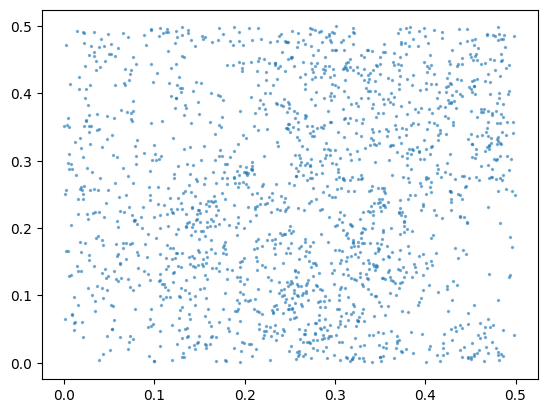

In [93]:
pb_target = pbox.PowerBox(
    N=512,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: 0.5*k**-2., # The power-spectrum
    boxlength = 0.5,           # Size of the box (sets the units of k in pk)
    seed = 1410,               # Set a seed to ensure the box looks the same every time (optional)
    ensure_physical=True       # ** Ensure the delta_x is a physically valid over-density **
)


# Create a discrete sample using the PowerBox instance.
samples_target = pb_target.create_discrete_sample(nbar=7000,      # nbar specifies the number density
                                    min_at_zero=True  # by default the samples are centred at 0. This shifts them to be positive.
                                   )

samples_target = torch.tensor(samples_target)

# Plot the samples
plt.scatter(samples_target[:,0],samples_target[:,1], alpha=0.5, s=2)
plt.show()

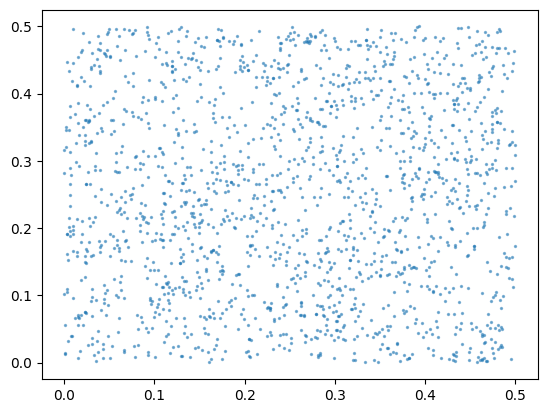

In [94]:
pb_init = pbox.PowerBox(
    N=512,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: 0.5*k**-1., # The power-spectrum
    boxlength = 0.5,           # Size of the box (sets the units of k in pk)
    seed = 1410,               # Set a seed to ensure the box looks the same every time (optional)
    ensure_physical=True       # ** Ensure the delta_x is a physically valid over-density **
)


# Create a discrete sample using the PowerBox instance.
samples_init = pb_init.create_discrete_sample(nbar=1000,      # nbar specifies the number density
                                    min_at_zero=True  # by default the samples are centred at 0. This shifts them to be positive.
                                   )

# Plot the samples
plt.scatter(samples_init[:,0],samples_init[:,1], alpha=0.5, s=2)
plt.show()


In [95]:
print(len(samples_init))
print(samples_target.size(dim=0))

1773
1745


In [96]:
# Creation of the PD that we want to get to
goal_pd = gen_data.create_hybrid_dtm_pd(samples_target)

/Users/sliemela/Google Drive/Education/UvA/Double Master/Thesis/masterthesis/Programming/Inverse Optimization/src/inverse_optim/gen_data.py:270: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if init_pts == "random":
100%|██████████| 200/200 [01:53<00:00,  1.77it/s]
/Users/sliemela/Google Drive/Education/UvA/Double Master/Thesis/masterthesis/Programming/Inverse Optimization/src/inverse_optim/gen_data.py:270: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if init_pts == "random":
100%|██████████| 200/200 [01:44<00:00,  1.92it/s]
/Users/sliemela/Google Drive/Education/UvA/Double Master/Thesis/masterthesis/Programming/Inverse Optimization/src/inverse_optim/gen_data.py:270: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if init_pts == "random":
100%|█

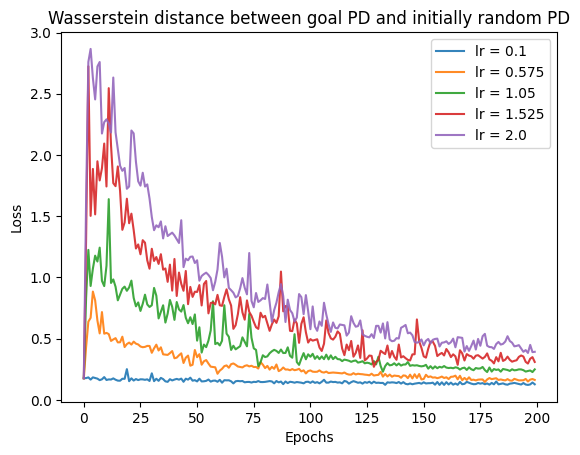

In [97]:
lr_list = np.linspace(0.1, 2, 5)
research_plot.research_lr(lr_list=lr_list, goal_pd=goal_pd, amount=samples_target.size(dim=0), dim=2, epochs=200, decay_speed=30, sliced=0.5, filtr="alpha_dtm", init_pts=samples_init)

/Users/sliemela/Google Drive/Education/UvA/Double Master/Thesis/masterthesis/Programming/Inverse Optimization/src/inverse_optim/gen_data.py:270: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if init_pts == "random":


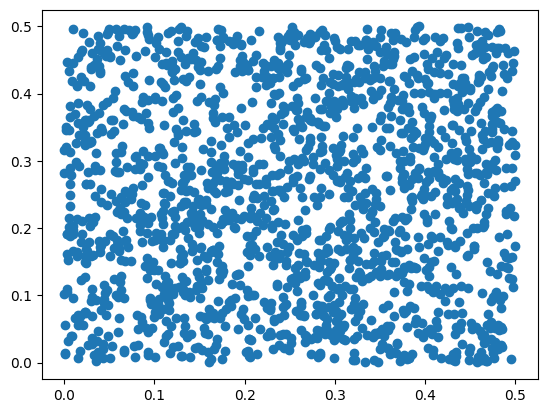

 33%|███▎      | 99/300 [00:31<02:00,  1.67it/s]

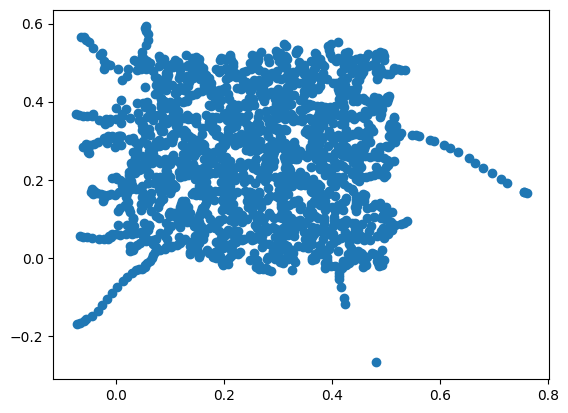

 66%|██████▋   | 199/300 [00:59<00:27,  3.69it/s]

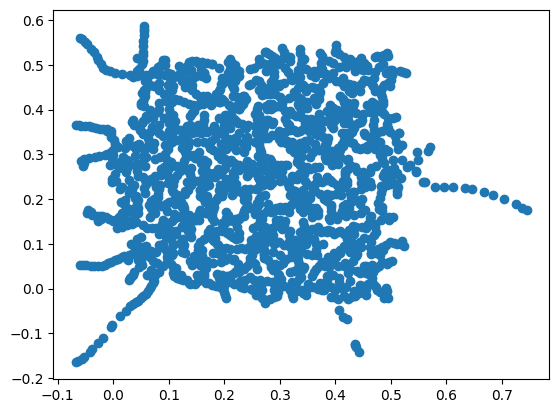

100%|█████████▉| 299/300 [01:26<00:00,  3.76it/s]

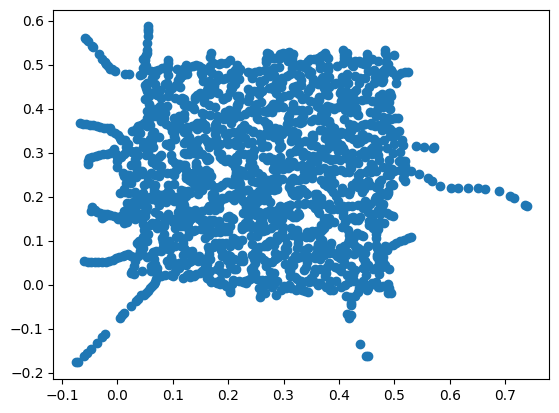

100%|██████████| 300/300 [01:26<00:00,  3.46it/s]


In [99]:
final_pts = gen_data.generate_data(goal_pd=goal_pd, amount=samples_target.size(dim=0), lr=0.68, dim=2, epochs=300, decay_speed=30, sliced=0.5, filtr="alpha_dtm", init_pts=samples_init)

In [100]:
# The number of grid points are also required when passing the samples
p_k_samples_target, bins_samples_target = pbox.get_power(samples_target.detach().numpy(), pb_target.boxlength, N=pb_target.N)
p_k_samples_init, bins_samples_init = pbox.get_power(samples_init, pb_init.boxlength, N=pb_init.N)
p_k_samples_new, bins_samples_new = pbox.get_power(final_pts.detach().numpy(), pb_target.boxlength, N=pb_target.N)

/Users/sliemela/Environments/inverse_optim_env/lib/python3.7/site-packages/powerbox/dft.py:121: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")


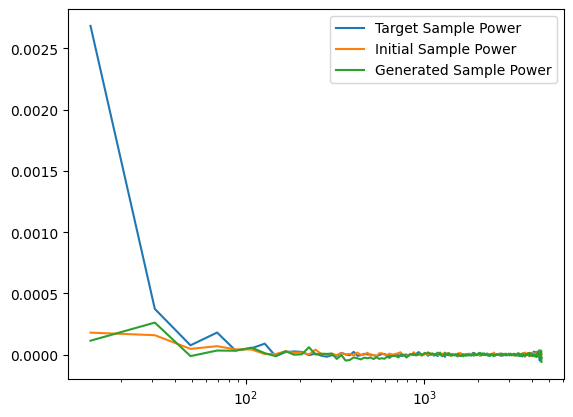

In [104]:
plt.plot(bins_samples_target, p_k_samples_target,label="Target Sample Power")
plt.plot(bins_samples_init, p_k_samples_init,label="Initial Sample Power")
plt.plot(bins_samples_new, p_k_samples_new,label="Generated Sample Power")

plt.legend()
plt.xscale('log')
# plt.yscale('log')

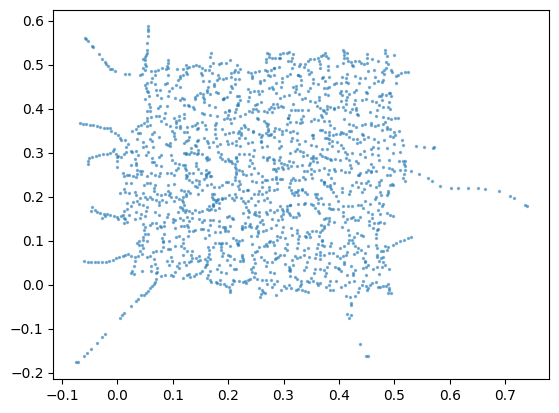

In [105]:
# Plot the samples
plt.scatter(final_pts.detach().numpy()[:,0],final_pts.detach().numpy()[:,1], alpha=0.5, s=2)
plt.show()